# Importazione librerie

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
import pdb
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.preprocessing import StandardScaler

# Definizione delle funzioni e della rete neurale

In [2]:
def compute_output_size(height, width, conv_params, pool_params):
    """
    Calcola le dimensioni dell'output dopo i layer convolutivi e di pooling alternati.

    Args:
        height (int): Altezza dell'immagine in input.
        width (int): Larghezza dell'immagine in input.
        conv_params (list of tuples): Parametri dei layer convolutivi.
            Ogni tupla deve contenere (kernel_size, stride, padding).
            pool_params (list of tuples): Parametri dei layer di max pooling.
            Ogni tupla deve contenere (kernel_size, stride).

    Returns:
        tuple: Una tupla contenente le dimensioni dell'output (output_height, output_width).
    """
    for i in range(len(conv_params)):
        # Calcolo delle dimensioni dell'output dopo il layer convolutivo
        kernel_size, stride, padding = conv_params[i]
        height = ((height + 2 * padding - kernel_size) // stride) + 1
        width = ((width + 2 * padding - kernel_size) // stride) + 1

        if i < len(pool_params):
            # Se ci sono layer di pooling successivi, calcola le dimensioni dell'output dopo il layer di max pooling
            kernel_size, stride = pool_params[i]
            height = (height - kernel_size) // stride + 1
            width = (width - kernel_size) // stride + 1

    return height, width


def calculate_metrics(predictions, targets):
    predictions = predictions.cpu().detach().numpy()  # Applica la sigmoide per ottenere probabilità
    predictions = (predictions > 0.5).astype(int)  # Applica una soglia di 0.5 e converte in 0 o 1
    targets = targets.cpu().detach().numpy()  # Converte le etichette in un array NumPy
    accuracy = accuracy_score(targets, predictions)  # Calcola l'accuratezza
    return accuracy


# DEFINIZIONE DELLA RETE

In [3]:
class CNN(nn.Module):
    def __init__(self,
                 lunghezza_vettore=46,  # lunghezza del vettore
                 canali_input=1,  # numero di canali di input
                 num_classi=1,  # numero di classi
                 ):
        super(CNN, self).__init__()

        self.lunghezza_vettore = lunghezza_vettore
        self.colonne_encoding = 20
        self.canali_input = canali_input
        self.num_classi = num_classi
        
        self.encoding_row = nn.Parameter(torch.randn(1, self.colonne_encoding))

        
        self.conv1 = nn.Conv2d(canali_input, 6, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=1)

        # Calcolo delle dimensioni di output dopo le convoluzioni
        altezza_immagine = lunghezza_vettore
        larghezza_immagine = self.colonne_encoding
        conv_params = [(5, 1, 1), (5, 1, 1)]
        pool_params = []
        self.output_height, self.output_width = compute_output_size(altezza_immagine, larghezza_immagine, conv_params, pool_params)

        # Fully Connected layer
        self.fc = nn.Linear(384, num_classi)

    def forward(self, x):        
        batch_size = x.size(0)  # Prendi la dimensione del batch
        #print("dimensioni x iniziali:", x.shape)
        x = x.unsqueeze(1) 
        #print("dimensioni dopo unsqueeze:", x.shape)
        x = x.transpose(1, 2) # Trasposizione di ogni vettore del batch      
        #print("Dimensioni dell'input x dopo la trasposizione:", x.shape)
        encoding_matrix = self.encoding_row.repeat(batch_size, 1, 1)
        #print("dimensioni del vettore di encoding:", encoding_matrix.shape)
        x = torch.bmm(x, encoding_matrix)
        #print("Dimensioni dell'immagine dopo la moltiplicazione batch-wise:", x.shape)  # (batch_size, lunghezza_vettore, colonne_encoding)
        x = x.unsqueeze(1)  # (batch_size, 1, lunghezza_vettore, colonne_encoding)
        #print("dimensione dopo unsqueeze:", x.shape)

        # Passaggio attraverso i layer convoluzionali
        x = self.pool(F.relu(self.conv1(x)))  # Applica conv1 e poi max pooling
        #print("dimensioni dopo la prima conv:", x.shape)
        x = self.pool(F.relu(self.conv2(x)))  # Applica conv2 e poi max pooling

        #print("dimensioni dopo le convoluzioni:", x.shape)
        # Flatten per il fully connected
        #print("dimensioni prima del flattening:", x.shape)
        x = x.view(x.size(0), -1)

        #print("dimensioni dopo il flattening:", x.shape)
        #print("dimensioni previste:", self.output_height, self.output_width)
        
        # Fully connected
        x = self.fc(x)

        # Applica la sigmoid per la classificazione binaria
        x = torch.sigmoid(x)
        
        return x

# DATASET

In [ ]:
dataset=pd.read_csv("dataset_no_correlazioni.csv")
print(dataset.columns)
dataset[' Label'] = dataset[' Label'].map({'BENIGN': 0}).fillna(1).astype(int)
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

labels = dataset[' Label']
features = dataset.drop(columns=[' Label'])

# Applica lo StandardScaler solo alle feature
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Crea un nuovo DataFrame con le feature normalizzate
dataset_normalized = pd.DataFrame(features_normalized, columns=features.columns)

# Aggiungi di nuovo la colonna 'Label' al dataset normalizzato
dataset_normalized[' Label'] = labels.reset_index(drop=True)

X = dataset_normalized.drop(columns=[' Label']).values
y = dataset_normalized[' Label'].values   # Converte le etichette in numeri

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       ' Total Length of Bwd Packets', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow IAT Min', ' Fwd IAT Max', 'Bwd IAT Total', ' Bwd IAT Std',
       ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance', ' SYN Flag Count', ' RST Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' Down/Up Ratio', ' Avg Bwd Segment Size', ' Fwd Header Length.1',
       'Subflow Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', ' Idle Std', ' Inbound', ' Label'],
      dtype='object')


In [42]:
dataset.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       ' Total Length of Bwd Packets', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow IAT Min', ' Fwd IAT Max', 'Bwd IAT Total', ' Bwd IAT Std',
       ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance', ' SYN Flag Count', ' RST Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' Down/Up Ratio', ' Avg Bwd Segment Size', ' Fwd Header Length.1',
       'Subflow Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', ' Idle Std', ' Inbound', ' Label'],
      dtype='object')

In [17]:
counter=dataset[" Label"].value_counts()

In [22]:
counter[1]

96028

# Definizione parametri della rete

In [43]:
from collections import Counter

n_epochs = 5
batch_size = 32
lr = 0.0001
plotting_freq = 1
losses_list = []


# Crea un tensore con i pesi in ordine di classe (es: [peso_classe_0, peso_classe_1])
weight_class_0=counter[1]/len(dataset)
weight_class_1=counter[0]/len(dataset)
class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float32)


lunghezza_vettore = X.shape[1]
model = CNN(lunghezza_vettore=lunghezza_vettore).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verifica la dimensione dei batch
for batch in train_loader:
    inputs, labels = batch
    print(f'Batch dimensioni: {inputs.shape}, {labels.shape}')  # Dovrebbe mostrare (batch_size, lunghezza) per inputs
    break  # Mostra solo il primo batch
# loss function e ottimizzatore
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Batch dimensioni: torch.Size([32, 40]), torch.Size([32])


# Training della rete

In [44]:
# training del modello
model.train()
history = []
print("inizio del training del modello")
for epoch in tqdm(range(n_epochs)):
    train_loss = 0.0
    train_accuracy = 0.0
    print("epoca numero:", epoch)
    for i, (images, labels) in enumerate(train_loader):
        print("Batch", i, "di", len(train_loader))
        images, labels = images.to(device), labels.to(device).float()
        #pdb.set_trace()
        yhat = model(images).squeeze(1)
        #print("previsione:", yhat)
        #print("label vera:", labels)
        batch_weights = class_weights[labels.long()]
        
        # Definisci la funzione di perdita
        loss_fn = nn.BCELoss(weight=batch_weights)
        

        loss = loss_fn(yhat, labels)
        #print("loss:", loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        accuracy = calculate_metrics(yhat, labels)
        train_accuracy += accuracy
        #train_f1 += f1

    avg_train_loss = train_loss / len(train_loader)
    avg_train_accuracy = train_accuracy / len(train_loader)
    #avg_train_f1 = train_f1 / len(train_loader)
    print(f"Epoca [{epoch + 1}/{n_epochs}] - Loss media: {avg_train_loss:.4f} - Accuracy: {avg_train_accuracy:.4f}")#- F1 Score: {avg_train_f1:.4f}")
    history.append(avg_train_loss)

print("Fine del training del modello")
print(history)
#sns.lineplot(history).set_title('Loss vs Epoch')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.savefig('loss_plot_04_05.png')




print("salvataggio del modello")
torch.save(model.state_dict(), 'model_weights.pth')
print("salvataggio del dataset di test")
torch.save(test_dataset, 'test_dataset.pth') 

inizio del training del modello


  0%|          | 0/5 [00:00<?, ?it/s]

epoca numero: 0
Batch 0 di 2708


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x384 and 432x1)

Test Loss: 0.3146
Accuracy: 0.9983
F1 Score: 0.9992
Recall: 0.9998


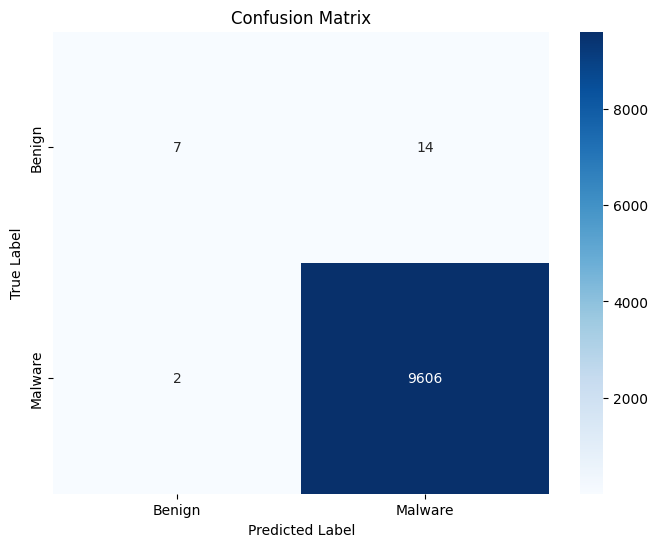

In [36]:
import torch
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Metti il modello in modalità di valutazione
model.eval()

# Variabili per tenere traccia delle predizioni e delle etichette reali
all_preds = []
all_labels = []
test_loss = 0.0

# Disattiva il calcolo dei gradienti
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        
        # Ottieni le predizioni
        yhat = model(images).squeeze(1)
        
        # Calcola il loss
        # I pesi non vengono usati qui, poiché stiamo solo calcolando il loss per le metriche
        loss = nn.BCEWithLogitsLoss()(yhat, labels)  # Puoi anche usare loss_fn se l'hai definita prima
        test_loss += loss.item()
        
        # Applica una soglia di 0.5 per classificare come 0 o 1 (adatto per output di tipo sigmoid)
        preds = (torch.sigmoid(yhat) > 0.5).float()  # Assicurati di applicare sigmoid per convertire in probabilità
        
        # Memorizza le predizioni e le etichette vere
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcola il loss medio sul test set
avg_test_loss = test_loss / len(test_loader)

# Calcola altre metriche
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)

# Stampa le metriche
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Calcola e visualizza la matrice di confusione
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()